In [1]:
#Library Imports
import numpy as np
import pandas as pd
import math
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn.model_selection import GridSearchCV

In [2]:
train=pd.read_csv('C:/Users/dustn/Desktop/energy/train.csv')
test=pd.read_csv('C:/Users/dustn/Desktop/energy/test.csv')
submission=pd.read_csv('C:/Users/dustn/Desktop/energy/sample_submission.csv')

In [3]:
train.loc[train['date_time'] == '2020-08-12 12'].describe()
# 강수량이 없는 지역과 있는 지역 - 바다일 확률 높음
# 8월 17일은 임시공휴일

,num,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,30.500000,3367.560051,28.453333,1.668333,83.916667,0.303333,0.173333,0.683333,0.483333
std,17.464249,2652.442872,1.565352,1.284654,8.762965,0.725087,0.276091,0.469102,0.503939
min,1.000000,933.390000,25.500000,0.100000,54.000000,0.000000,0.000000,0.000000,0.000000
25%,15.750000,1822.135500,28.100000,1.000000,82.000000,0.000000,0.000000,0.000000,0.000000
50%,30.500000,2652.178500,28.200000,1.400000,82.000000,0.000000,0.000000,1.000000,0.000000
75%,45.250000,3517.293643,29.400000,1.700000,89.000000,0.000000,0.200000,1.000000,1.000000
max,60.000000,15999.705000,34.000000,7.600000,99.000000,3.200000,1.000000,1.000000,1.000000


In [4]:
#가스 냉방은 전기가 아닌 가스를 에너지원으로 하는 냉방시설로, 661㎡(약 200평) 규모 이상 건물에서 활용할 수 있다. 가정이 아니라 회의장 같은 대형 건물에서 사용한다.

#가스 냉방은 여름철에 전력 수요를 완화할 수 있는 합리적인 수단으로 꼽히지만, 초기투자비와 유지보수비용이 많이 드는 점이 보급에 걸림돌로 꼽혀왔다. 2016년부터 정부의 가스 냉방 보조금 예산도 급격히 줄면서 보급도 정체된 상황이다.

In [5]:
#test.shape 10080 X 9
#60개의 건물 X 7일 24시간 =10080
test

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유
0,1,2020-08-25 00,27.8,1.5,74.0,0.0,0.0,NaN,NaN
1,1,2020-08-25 01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2020-08-25 02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2020-08-25 03,27.3,1.1,78.0,NaN,0.0,NaN,NaN
4,1,2020-08-25 04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
10075,60,2020-08-31 19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10076,60,2020-08-31 20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10077,60,2020-08-31 21,27.9,4.1,68.0,NaN,0.0,1.0,1.0
10078,60,2020-08-31 22,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# **데이터 전처리**

In [6]:
#건물별로 '비전기냉방설비운영'과 '태양광보유'를 판단해 test set의 결측치를 보간해줍니다
train[['num', '비전기냉방설비운영','태양광보유']]
ice={}
hot={}
count=0
for i in range(0, len(train), len(train)//60):
    count +=1
    ice[count]=train.loc[i,'비전기냉방설비운영']
    hot[count]=train.loc[i,'태양광보유']
    

In [7]:
for i in range(len(test)):
    test.loc[i, '비전기냉방설비운영']=ice[test['num'][i]]
    test.loc[i, '태양광보유']=hot[test['num'][i]]

In [8]:
test

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유
0,1,2020-08-25 00,27.8,1.5,74.0,0.0,0.0,0.0,0.0
1,1,2020-08-25 01,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2,1,2020-08-25 02,NaN,NaN,NaN,NaN,NaN,0.0,0.0
3,1,2020-08-25 03,27.3,1.1,78.0,NaN,0.0,0.0,0.0
4,1,2020-08-25 04,NaN,NaN,NaN,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...
10075,60,2020-08-31 19,NaN,NaN,NaN,NaN,NaN,1.0,1.0
10076,60,2020-08-31 20,NaN,NaN,NaN,NaN,NaN,1.0,1.0
10077,60,2020-08-31 21,27.9,4.1,68.0,NaN,0.0,1.0,1.0
10078,60,2020-08-31 22,NaN,NaN,NaN,NaN,NaN,1.0,1.0


In [9]:
#시간 변수와 요일 변수를 추가해봅니다.
def time(x):
    return int(x[-2:])
train['time']=train['date_time'].apply(lambda x: time(x))
test['time']=test['date_time'].apply(lambda x: time(x))

def weekday(x):
    return pd.to_datetime(x[:10]).weekday()
train['weekday']=train['date_time'].apply(lambda x :weekday(x))
test['weekday']=test['date_time'].apply(lambda x :weekday(x))

def month(x):
    return int(x[5:7])
train['month']=train['date_time'].apply(lambda x: month(x))
test['month']=test['date_time'].apply(lambda x: month(x))

In [10]:
# from datetime import datetime
# a=datetime.strptime('2021-05-16', '%Y-%m-%d')
# a.weekday()

In [11]:
test.info() # 습도로 강수량 데이터 예측(습도보다 강수량 데이터가 절반 정도 적으므로)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10080 entries, 0 to 10079
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num           10080 non-null  int64  
 1   date_time     10080 non-null  object 
 2   기온(°C)        3360 non-null   float64
 3   풍속(m/s)       3360 non-null   float64
 4   습도(%)         3360 non-null   float64
 5   강수량(mm, 6시간)  1680 non-null   float64
 6   일조(hr, 3시간)   3360 non-null   float64
 7   비전기냉방설비운영     10080 non-null  float64
 8   태양광보유         10080 non-null  float64
 9   time          10080 non-null  int64  
 10  weekday       10080 non-null  int64  
 11  month         10080 non-null  int64  
dtypes: float64(7), int64(4), object(1)
memory usage: 945.1+ KB


+ test 결측치 보간해줍니다.
+ test 데이터의 변수는 예보 데이터이며, 예보 데이터는 train 데이터의 기간에 생성된 것이기에 활용 가능합니다.

In [12]:
test=test.interpolate(method='values')

In [13]:
test # 기온, 풍속, 습도 등 따로 예측해서 넣는게 좋을듯

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유,time,weekday,month
0,1,2020-08-25 00,27.800000,1.500000,74.000000,0.0,0.000000,0.0,0.0,0,1,8
1,1,2020-08-25 01,27.633333,1.366667,75.333333,0.0,0.000000,0.0,0.0,1,1,8
2,1,2020-08-25 02,27.466667,1.233333,76.666667,0.0,0.000000,0.0,0.0,2,1,8
3,1,2020-08-25 03,27.300000,1.100000,78.000000,0.0,0.000000,0.0,0.0,3,1,8
4,1,2020-08-25 04,26.900000,1.166667,79.666667,0.0,0.000000,0.0,0.0,4,1,8
...,...,...,...,...,...,...,...,...,...,...,...,...
10075,60,2020-08-31 19,28.633333,3.566667,66.000000,0.0,0.533333,1.0,1.0,19,0,8
10076,60,2020-08-31 20,28.266667,3.833333,67.000000,0.0,0.266667,1.0,1.0,20,0,8
10077,60,2020-08-31 21,27.900000,4.100000,68.000000,0.0,0.000000,1.0,1.0,21,0,8
10078,60,2020-08-31 22,27.900000,4.100000,68.000000,0.0,0.000000,1.0,1.0,22,0,8


In [14]:
train

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,time,weekday,month
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,0,0,6
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,1,0,6
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,2,0,6
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,3,0,6
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,4,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0,19,0,8
122396,60,2020-08-24 20,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0,20,0,8
122397,60,2020-08-24 21,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0,21,0,8
122398,60,2020-08-24 22,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0,22,0,8


In [15]:
# 시간별 전력사용량 모음
b_dict={}
for k in range(1,61):
    sort_time=[]
    for i in range(24):
        sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))    
    sort_time_number=[]
    for i,j in enumerate(sort_time):
        if j in sorted(sort_time, reverse=True)[:10]:
            sort_time_number.append(i)
    b_dict[k]=sort_time_number
b_dict    

<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarnin

<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarnin

<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarnin

<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarnin

<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarnin

<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarnin

<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarnin

<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarnin

<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarnin

<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarnin

<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarnin

<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarnin

<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarnin

<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarnin

<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarnin

<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarnin

<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarnin

<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarnin

<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarnin

<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarnin

<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarnin

<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarnin

<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarnin

<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarnin

<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarnin

<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarnin

<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))
<ipython-input-15-45af630b8c02>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sort_time.append(sum(train[train['num']==k][train['time']==i]['전력사용량(kWh)']))


{1: [13, 14, 15, 16, 17, 18, 19, 20, 21, 22],
 2: [8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 3: [1, 3, 4, 5, 6, 7, 8, 16, 17, 23],
 4: [9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 5: [0, 1, 2, 3, 4, 11, 20, 21, 22, 23],
 6: [9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 7: [8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 8: [8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 9: [0, 1, 2, 3, 18, 19, 20, 21, 22, 23],
 10: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 11: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 12: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 13: [8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 14: [8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 15: [0, 1, 2, 7, 8, 13, 15, 16, 17, 23],
 16: [8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 17: [8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 18: [9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 19: [10, 12, 14, 17, 18, 19, 20, 21, 22, 23],
 20: [11, 12, 13, 17, 18, 19, 20, 21, 22, 23],
 21: [12, 13, 15, 16, 17, 18, 19, 20, 21, 22],
 22: [9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 23: [8, 9, 10

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   num         122400 non-null  int64  
 1   date_time   122400 non-null  object 
 2   전력사용량(kWh)  122400 non-null  float64
 3   기온(°C)      122400 non-null  float64
 4   풍속(m/s)     122400 non-null  float64
 5   습도(%)       122400 non-null  float64
 6   강수량(mm)     122400 non-null  float64
 7   일조(hr)      122400 non-null  float64
 8   비전기냉방설비운영   122400 non-null  float64
 9   태양광보유       122400 non-null  float64
 10  time        122400 non-null  int64  
 11  weekday     122400 non-null  int64  
 12  month       122400 non-null  int64  
dtypes: float64(8), int64(4), object(1)
memory usage: 12.1+ MB


In [17]:
train.describe()

,num,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,time,weekday,month
count,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000
mean,30.500000,2324.830866,24.251713,2.151641,80.169848,0.514989,0.213533,0.683333,0.483333,11.500000,2.964706,6.929412
std,17.318173,2058.999326,3.407902,1.514475,15.525862,2.624505,0.370517,0.465178,0.499724,6.922215,2.014351,0.793925
min,1.000000,0.000000,11.100000,0.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000
25%,15.750000,1055.268000,21.800000,1.100000,70.000000,0.000000,0.000000,0.000000,0.000000,5.750000,1.000000,6.000000
50%,30.500000,1700.352000,24.200000,1.900000,84.000000,0.000000,0.000000,1.000000,0.000000,11.500000,3.000000,7.000000
75%,45.250000,2780.487000,26.500000,2.900000,93.000000,0.000000,0.300000,1.000000,1.000000,17.250000,5.000000,8.000000
max,60.000000,17739.225000,36.300000,20.100000,100.000000,81.500000,1.000000,1.000000,1.000000,23.000000,6.000000,8.000000


C:\Users\dustn\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51204 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\dustn\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 47141 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\dustn\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\dustn\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 50857 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\dustn\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\dustn\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 51204 missing from c

<AxesSubplot:>

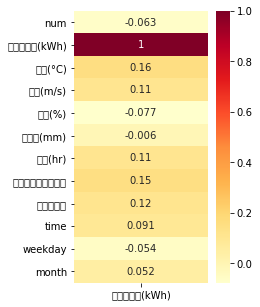

In [18]:
fig = plt.figure(figsize=(3,5))
sns.heatmap(train.corr()[['전력사용량(kWh)']], annot=True,cmap='YlOrRd')

In [19]:
# train.loc[train['num'] == 11][['전력사용량(kWh)','기온(°C)','풍속(m/s)','습도(%)','강수량(mm)','일조(hr)']].describe()

In [20]:
# for i in range(1,61):
#     print(i)
#     print('-'*10)
#     print(train.loc[train['num'] == i][['강수량(mm)']].describe())


In [21]:
# for i in range(1,61):
#     print(i)
#     print('-'*10)
#     print(train.loc[train['date_time'] == '2020-08-12 10'].describe())

In [22]:
train

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,time,weekday,month
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,0,0,6
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,1,0,6
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,2,0,6
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,3,0,6
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,4,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0,19,0,8
122396,60,2020-08-24 20,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0,20,0,8
122397,60,2020-08-24 21,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0,21,0,8
122398,60,2020-08-24 22,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0,22,0,8


In [23]:
for i,j in enumerate(b_dict.values()):
    train['peak time'][train['num']==i+1]=train['time'][train['num']==i+1].apply(lambda s:'peak' if s in j else 'break')

KeyError: 'peak time'

In [24]:
weekday=['0','1','2','3','4']
weekend=['5','6']


train['new_weekday'] = train['weekday'].apply(lambda s: 'weekday' if str(s) in weekday else 'weekend')

In [25]:
weekday=['0','1','2','3','4']
weekend=['5','6']


test['new_weekday'] = test['weekday'].apply(lambda s: 'weekday' if str(s) in weekday else 'weekend')

In [26]:
morning=['8','9','10','11','12','13','14','15','16','17','18','19','20']
# night=[20,21,22,23,0,1,2,3,4,5,6,7]


train['new_time'] = train['time'].apply(lambda s: 'morning' if str(s) in morning else 'night')

In [27]:
morning=['9','10','11','12','13','14','15','16','17','18']
night=[19,20,21,22,23,0,1,2,3,4,5,6,7,8]


test['new_time'] = test['time'].apply(lambda s: 'morning' if str(s) in morning else 'night')

In [28]:
train[150:200]

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,time,weekday,month,new_weekday,new_time
150,1,2020-06-07 06,8472.600,19.6,1.8,78.0,0.0,0.0,0.0,0.0,6,6,6,weekend,night
151,1,2020-06-07 07,8506.296,19.6,2.1,78.0,0.0,0.0,0.0,0.0,7,6,6,weekend,night
152,1,2020-06-07 08,8533.512,20.1,1.9,78.0,0.0,0.0,0.0,0.0,8,6,6,weekend,morning
153,1,2020-06-07 09,8530.272,20.9,2.0,75.0,0.0,0.1,0.0,0.0,9,6,6,weekend,morning
154,1,2020-06-07 10,8559.432,22.4,2.4,69.0,0.0,0.3,0.0,0.0,10,6,6,weekend,morning
155,1,2020-06-07 11,8595.720,24.4,2.9,62.0,0.0,0.9,0.0,0.0,11,6,6,weekend,morning
156,1,2020-06-07 12,8569.800,24.8,2.3,61.0,0.0,1.0,0.0,0.0,12,6,6,weekend,morning
157,1,2020-06-07 13,8595.072,26.1,2.4,56.0,0.0,1.0,0.0,0.0,13,6,6,weekend,morning
158,1,2020-06-07 14,8619.048,27.4,1.7,50.0,0.0,1.0,0.0,0.0,14,6,6,weekend,morning
159,1,2020-06-07 15,8620.344,28.4,3.0,45.0,0.0,1.0,0.0,0.0,15,6,6,weekend,morning


In [29]:
test

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유,time,weekday,month,new_weekday,new_time
0,1,2020-08-25 00,27.800000,1.500000,74.000000,0.0,0.000000,0.0,0.0,0,1,8,weekday,night
1,1,2020-08-25 01,27.633333,1.366667,75.333333,0.0,0.000000,0.0,0.0,1,1,8,weekday,night
2,1,2020-08-25 02,27.466667,1.233333,76.666667,0.0,0.000000,0.0,0.0,2,1,8,weekday,night
3,1,2020-08-25 03,27.300000,1.100000,78.000000,0.0,0.000000,0.0,0.0,3,1,8,weekday,night
4,1,2020-08-25 04,26.900000,1.166667,79.666667,0.0,0.000000,0.0,0.0,4,1,8,weekday,night
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10075,60,2020-08-31 19,28.633333,3.566667,66.000000,0.0,0.533333,1.0,1.0,19,0,8,weekday,night
10076,60,2020-08-31 20,28.266667,3.833333,67.000000,0.0,0.266667,1.0,1.0,20,0,8,weekday,night
10077,60,2020-08-31 21,27.900000,4.100000,68.000000,0.0,0.000000,1.0,1.0,21,0,8,weekday,night
10078,60,2020-08-31 22,27.900000,4.100000,68.000000,0.0,0.000000,1.0,1.0,22,0,8,weekday,night


In [30]:
# plt.figure(figsize=(14, 300))
# for i in range(1,61):
#     plt.subplot(60,1,i).set_title('number'+str(i))
#     sns.barplot(train['time'][train['num']==i],train['전력사용량(kWh)'][train['num']==i])


# plt.show()

In [31]:
# plt.figure(figsize=(30, 10))
# sns.barplot(x='weekday',y='전력사용량(kWh)',data=train)


# plt.show()

In [32]:
# plt.figure(figsize=(30, 10))
# sns.barplot(x='month',y='전력사용량(kWh)',data=train)


# plt.show()

In [33]:
# plt.figure(figsize=(30, 10))
# sns.barplot(x='num',y='전력사용량(kWh)',data=train,hue='new_weekday')


# plt.show()

In [34]:
# plt.figure(figsize=(30, 10))
# sns.lmplot(x='습도(%)',y='전력사용량(kWh)',data=train)


# plt.show()

In [35]:
# sns.jointplot(x='풍속(m/s)', y='전력사용량(kWh)', data=train,alpha=0.1)

# **모델링**

In [36]:
train_x=train.drop('전력사용량(kWh)', axis=1)
train_y=train[['전력사용량(kWh)']]

In [37]:
train_x

,num,date_time,기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,time,weekday,month,new_weekday,new_time
0,1,2020-06-01 00,17.6,2.5,92.0,0.8,0.0,0.0,0.0,0,0,6,weekday,night
1,1,2020-06-01 01,17.7,2.9,91.0,0.3,0.0,0.0,0.0,1,0,6,weekday,night
2,1,2020-06-01 02,17.5,3.2,91.0,0.0,0.0,0.0,0.0,2,0,6,weekday,night
3,1,2020-06-01 03,17.1,3.2,91.0,0.0,0.0,0.0,0.0,3,0,6,weekday,night
4,1,2020-06-01 04,17.0,3.3,92.0,0.0,0.0,0.0,0.0,4,0,6,weekday,night
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19,27.8,2.3,68.0,0.0,0.7,1.0,1.0,19,0,8,weekday,morning
122396,60,2020-08-24 20,27.3,1.2,71.0,0.0,0.0,1.0,1.0,20,0,8,weekday,morning
122397,60,2020-08-24 21,27.3,1.8,71.0,0.0,0.0,1.0,1.0,21,0,8,weekday,night
122398,60,2020-08-24 22,27.1,1.8,74.0,0.0,0.0,1.0,1.0,22,0,8,weekday,night


In [38]:
scaler = StandardScaler() 
X_num = train_x[['기온(°C)','풍속(m/s)','습도(%)','강수량(mm)','일조(hr)','time','weekday','month']]
scaler.fit(X_num)  
X_scaled = scaler.transform(X_num)
X_scaled = pd.DataFrame(data=X_scaled, index=X_num.index, columns=X_num.columns)
X_cat = train_x[['new_weekday']]
# y = movie['num_viewers']0
X_cat=pd.get_dummies(X_cat,drop_first=True)
train_x = pd.concat([X_scaled, X_cat], axis=1)

In [39]:
test

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유,time,weekday,month,new_weekday,new_time
0,1,2020-08-25 00,27.800000,1.500000,74.000000,0.0,0.000000,0.0,0.0,0,1,8,weekday,night
1,1,2020-08-25 01,27.633333,1.366667,75.333333,0.0,0.000000,0.0,0.0,1,1,8,weekday,night
2,1,2020-08-25 02,27.466667,1.233333,76.666667,0.0,0.000000,0.0,0.0,2,1,8,weekday,night
3,1,2020-08-25 03,27.300000,1.100000,78.000000,0.0,0.000000,0.0,0.0,3,1,8,weekday,night
4,1,2020-08-25 04,26.900000,1.166667,79.666667,0.0,0.000000,0.0,0.0,4,1,8,weekday,night
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10075,60,2020-08-31 19,28.633333,3.566667,66.000000,0.0,0.533333,1.0,1.0,19,0,8,weekday,night
10076,60,2020-08-31 20,28.266667,3.833333,67.000000,0.0,0.266667,1.0,1.0,20,0,8,weekday,night
10077,60,2020-08-31 21,27.900000,4.100000,68.000000,0.0,0.000000,1.0,1.0,21,0,8,weekday,night
10078,60,2020-08-31 22,27.900000,4.100000,68.000000,0.0,0.000000,1.0,1.0,22,0,8,weekday,night


In [40]:
X_num = test[['기온(°C)','풍속(m/s)','습도(%)','강수량(mm, 6시간)','일조(hr, 3시간)','time','weekday','month']]
# scaler.fit(X_num)  
X_scaled = scaler.transform(X_num)
X_scaled = pd.DataFrame(data=X_scaled, index=X_num.index, columns=X_num.columns)
X_cat = test[['new_weekday']]
# y = movie['num_viewers']
X_cat=pd.get_dummies(X_cat,drop_first=True)
test = pd.concat([X_scaled, X_cat], axis=1)

In [ ]:
train_x['new_weekday_weekend'] = pd.to_numeric(train_x['new_weekday_weekend'])
test['new_weekday_weekend'] = pd.to_numeric(test['new_weekday_weekend'])

In [ ]:
# train_x['new_time_night'] = pd.to_numeric(train_x['new_time_night'])
# test['new_time_night'] = pd.to_numeric(test['new_time_night'])

In [ ]:
train_x

In [ ]:
test

In [ ]:
# train_x.drop('date_time', axis=1, inplace=True)
# test.drop('date_time', axis=1, inplace=True)

In [ ]:
# params = {'max_depth': [9,10],
#                   'min_child_samples': [5,10],
#                   'subsample': [0.0001,0.001]}
# lgbm = LGBMRegressor(n_estimators=200)
# model = GridSearchCV(lgbm, param_grid=params)
# model.fit(train_x, test, early_stopping_rounds=100, eval_metric='auc',
#                  eval_set=[(train_x, test), (X_valid, y_valid)])

# print("최적 파라미터: ", model.best_params_)

In [ ]:
# for i in range(3):
#     train_x2=train_x[i*24*85:(i+1)*24*85]
#     train_y2=train_y[i*24*85:(i+1)*24*85]
#     cross=KFold(n_splits=5, shuffle=True, random_state=42)
#     folds=[]

#     for train_idx, valid_idx in cross.split(train_x2, train_y2):
#         folds.append((train_idx, valid_idx))
#     models={}
#     for fold in range(5):
#         print(f'===================={fold+1}=======================')
#         train_idx, valid_idx=folds[fold]
#         X_train=train_x2.iloc[train_idx, :]
#         y_train=train_y2.iloc[train_idx, :]
#         X_valid=train_x2.iloc[valid_idx, :]
#         y_valid=train_y2.iloc[valid_idx, :]
#         params = {'max_depth': [9,10],
#                   'min_child_samples': [5,10],
#                   'subsample': [0.0001,0.001]}
#         lgbm = LGBMRegressor(n_estimators=200)
#         model = GridSearchCV(lgbm, param_grid=params)
#         model.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='auc',
#                      eval_set=[(X_train, y_train), (X_valid, y_valid)])

#         print("최적 파라미터: ", model.best_params_)

In [ ]:
# model.best_params_

In [ ]:
# lgbm = LGBMRegressor(n_estimators=1000, num_leaves=50, subsample=0.0001,
#                       min_child_samples=10, max_depth=10)

# evals = [(X_test, y_test)]
# lgbm.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='auc',
#          eval_set=evals, verbose=True)

In [ ]:
# final_list=[]
# for i in range(60):
#     train_x2=train_x[i*24*85:(i+1)*24*85]
#     train_y2=train_y[i*24*85:(i+1)*24*85]
#     cross=KFold(n_splits=5, shuffle=True, random_state=42)
#     folds=[]

#     for train_idx, valid_idx in cross.split(train_x2, train_y2):
#         folds.append((train_idx, valid_idx))
#     models={}
#     for fold in range(5):
#         print(f'===================={fold+1}=======================')
#         train_idx, valid_idx=folds[fold]
#         X_train=train_x2.iloc[train_idx, :]
#         y_train=train_y2.iloc[train_idx, :]
#         X_valid=train_x2.iloc[valid_idx, :]
#         y_valid=train_y2.iloc[valid_idx, :]
        
        
#         params = {'max_depth': [5,10,20],
#                   'min_child_samples': [5,10]}
#         lgbm = LGBMRegressor(n_estimators=200)
#         model = GridSearchCV(lgbm, param_grid=params)
#         model.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='auc',
#                      eval_set=[(X_train, y_train), (X_valid, y_valid)])
        
        
#         model=LGBMRegressor(n_estimators=200,num_leaves=50, subsample=0.0001,
#                       min_child_samples=model.best_params_['min_child_samples'], max_depth=model.best_params_['max_depth'])
#         model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], 
#                  early_stopping_rounds=100, eval_metric='auc',verbose=True)
#         models[fold]=model

#         print(f'================================================\n\n')
#     sum_list = [0 for i in range(168)]    
#     for j in range(5):
#         sum_list += models[j].predict(test[i*7*24:(i+1)*7*24])/5 
#     final_list.extend(sum_list)
#     print('now done ',i,'wwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwww')

In [41]:
final_list=[]
for i in range(60):
    train_x2=train_x[i*24*85:(i+1)*24*85]
    train_y2=train_y[i*24*85:(i+1)*24*85]
    cross=KFold(n_splits=5, shuffle=True, random_state=42)
    folds=[]
    print(len(train_x2))
    print(len(train_y2))
    for train_idx, valid_idx in cross.split(train_x2, train_y2):
        folds.append((train_idx, valid_idx))
    models={}
    for fold in range(5):
        print(f'===================={fold+1}=======================')
        train_idx, valid_idx=folds[fold]
        X_train=train_x2.iloc[train_idx, :]
        y_train=train_y2.iloc[train_idx, :]
        X_valid=train_x2.iloc[valid_idx, :]
        y_valid=train_y2.iloc[valid_idx, :]
        
        model=LGBMRegressor(n_estimators=1000)
        model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], 
                 early_stopping_rounds=1, verbose=100)
        models[fold]=model

        print(f'================================================\n\n')
    sum_list = [0 for i in range(168)]    
    for j in range(5):
        sum_list += models[j].predict(test[i*7*24:(i+1)*7*24])/5 
    final_list.extend(sum_list)
    

2040
2040
====================1=======================
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 825.604	valid_1's l2: 2390
[200]	training's l2: 446.396	valid_1's l2: 2252.32
[300]	training's l2: 294.508	valid_1's l2: 2220.09
[400]	training's l2: 210.218	valid_1's l2: 2200.27
[500]	training's l2: 155.643	valid_1's l2: 2214.14
Early stopping, best iteration is:
[425]	training's l2: 194.23	valid_1's l2: 2192.9


====================2=======================
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 837.046	valid_1's l2: 2137.2
[200]	training's l2: 430.428	valid_1's l2: 2044.7
[300]	training's l2: 290.683	valid_1's l2: 2036.44
Early stopping, best iteration is:
[274]	training's l2: 318.566	valid_1's l2: 2026.94


====================3=======================
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 661.456	valid_1's l2: 3444.41
[200]	training's l2: 350.52	valid_1's l2:

[100]	training's l2: 12847.4	valid_1's l2: 33709.3
[200]	training's l2: 6244.91	valid_1's l2: 32736.2
[300]	training's l2: 3684.38	valid_1's l2: 33159
Early stopping, best iteration is:
[209]	training's l2: 5928.38	valid_1's l2: 32678.7


====================4=======================
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 12382.8	valid_1's l2: 40494.9
[200]	training's l2: 6076.59	valid_1's l2: 38796
[300]	training's l2: 3558.64	valid_1's l2: 38624.3
Early stopping, best iteration is:
[231]	training's l2: 5110.41	valid_1's l2: 38428.7


====================5=======================
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 13262.4	valid_1's l2: 38048.3
[200]	training's l2: 6656.81	valid_1's l2: 34407.2
[300]	training's l2: 4052.62	valid_1's l2: 33837.6
[400]	training's l2: 2634.73	valid_1's l2: 34009.4
Early stopping, best iteration is:
[303]	training's l2: 4004.23	valid_1's l2: 33812.9


2040
2040
======

[100]	training's l2: 572.527	valid_1's l2: 1852.27
[200]	training's l2: 309.506	valid_1's l2: 1861.33
Early stopping, best iteration is:
[116]	training's l2: 509.813	valid_1's l2: 1835.49


====================3=======================
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 590.338	valid_1's l2: 1929.38
Early stopping, best iteration is:
[92]	training's l2: 623.541	valid_1's l2: 1925.94


====================4=======================
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 568.114	valid_1's l2: 2190.3
[200]	training's l2: 301.896	valid_1's l2: 2130.94
[300]	training's l2: 190.83	valid_1's l2: 2150.29
Early stopping, best iteration is:
[204]	training's l2: 296.816	valid_1's l2: 2123.6


====================5=======================
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 584.347	valid_1's l2: 1639.44
Early stopping, best iteration is:
[70]	training's l2: 762.67	

[100]	training's l2: 1007.94	valid_1's l2: 4616.26
[200]	training's l2: 530.28	valid_1's l2: 4287.78
[300]	training's l2: 328.464	valid_1's l2: 4213.07
[400]	training's l2: 216.721	valid_1's l2: 4186.9
Early stopping, best iteration is:
[390]	training's l2: 225.423	valid_1's l2: 4176.75


2040
2040
====================1=======================
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 3143.23	valid_1's l2: 7805.92
[200]	training's l2: 1624.5	valid_1's l2: 7621.89
[300]	training's l2: 962.527	valid_1's l2: 7556.88
Early stopping, best iteration is:
[268]	training's l2: 1123.6	valid_1's l2: 7516.98


====================2=======================
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 2829.73	valid_1's l2: 10962.9
[200]	training's l2: 1423.45	valid_1's l2: 10857.5
[300]	training's l2: 804.913	valid_1's l2: 10703.3
Early stopping, best iteration is:
[292]	training's l2: 838.187	valid_1's l2: 10699.3


======

[100]	training's l2: 14142	valid_1's l2: 45452.7
[200]	training's l2: 7580.82	valid_1's l2: 45178.9
Early stopping, best iteration is:
[141]	training's l2: 10780.6	valid_1's l2: 44817.6


====================5=======================
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 13853.6	valid_1's l2: 46332.3
Early stopping, best iteration is:
[49]	training's l2: 23264.6	valid_1's l2: 44389.4


2040
2040
====================1=======================
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 442.747	valid_1's l2: 1759.95
Early stopping, best iteration is:
[90]	training's l2: 483.361	valid_1's l2: 1746.98


====================2=======================
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 508.669	valid_1's l2: 1672.92
[200]	training's l2: 260.428	valid_1's l2: 1520.08
[300]	training's l2: 169.736	valid_1's l2: 1499.56
Early stopping, best iteration is:
[237]	training's 

[100]	training's l2: 997.442	valid_1's l2: 5412.88
[200]	training's l2: 525.978	valid_1's l2: 5452
Early stopping, best iteration is:
[135]	training's l2: 765.75	valid_1's l2: 5284.59


2040
2040
====================1=======================
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 7231.28	valid_1's l2: 32805.4
Early stopping, best iteration is:
[55]	training's l2: 11148.6	valid_1's l2: 32485.6


====================2=======================
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 7978.69	valid_1's l2: 24836
Early stopping, best iteration is:
[80]	training's l2: 9364.39	valid_1's l2: 24607


====================3=======================
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 8117.04	valid_1's l2: 20485.9
Early stopping, best iteration is:
[48]	training's l2: 13613.9	valid_1's l2: 19877.4


====================4=======================
Training until validation sc

[139]	training's l2: 1631.62	valid_1's l2: 5242.16


====================3=======================
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 2064.74	valid_1's l2: 5060.75
[200]	training's l2: 1166.47	valid_1's l2: 5127.6
Early stopping, best iteration is:
[120]	training's l2: 1819.43	valid_1's l2: 4999.63


====================4=======================
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 1838.3	valid_1's l2: 7379.58
Early stopping, best iteration is:
[67]	training's l2: 2446.53	valid_1's l2: 7014.61


====================5=======================
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 1775.35	valid_1's l2: 8391.12
Early stopping, best iteration is:
[72]	training's l2: 2269.6	valid_1's l2: 8355.6


2040
2040
====================1=======================
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 3609.51	valid_1's l2: 1152

2040
2040
====================1=======================
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 46.286	valid_1's l2: 134.646
[200]	training's l2: 24.5885	valid_1's l2: 128.567
[300]	training's l2: 15.1729	valid_1's l2: 129.123
Early stopping, best iteration is:
[207]	training's l2: 23.6024	valid_1's l2: 128.115


====================2=======================
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 46.8862	valid_1's l2: 127.668
[200]	training's l2: 26.2513	valid_1's l2: 129.37
Early stopping, best iteration is:
[136]	training's l2: 37.0193	valid_1's l2: 127.074


====================3=======================
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 45.8161	valid_1's l2: 151.475
[200]	training's l2: 25.3727	valid_1's l2: 149.656
Early stopping, best iteration is:
[190]	training's l2: 26.58	valid_1's l2: 149.098


====================4=======================
Trainin

[500]	training's l2: 136.699	valid_1's l2: 3234.03
[600]	training's l2: 99.6982	valid_1's l2: 3233.22
[700]	training's l2: 75.1419	valid_1's l2: 3238.44
Early stopping, best iteration is:
[612]	training's l2: 96.3352	valid_1's l2: 3228.37


====================2=======================
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 903.492	valid_1's l2: 2212.88
[200]	training's l2: 508.454	valid_1's l2: 2149.86
[300]	training's l2: 295.83	valid_1's l2: 2125.62
Early stopping, best iteration is:
[275]	training's l2: 334.134	valid_1's l2: 2122.11


====================3=======================
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 919.846	valid_1's l2: 1758.4
[200]	training's l2: 480.399	valid_1's l2: 1782
Early stopping, best iteration is:
[122]	training's l2: 782.498	valid_1's l2: 1745.44


====================4=======================
Training until validation scores don't improve for 100 rounds
[100]	traini

[100]	training's l2: 25436.5	valid_1's l2: 57662.4
Early stopping, best iteration is:
[76]	training's l2: 31200.6	valid_1's l2: 57196.6


====================5=======================
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 23176.9	valid_1's l2: 109476
Early stopping, best iteration is:
[60]	training's l2: 33212	valid_1's l2: 105708


2040
2040
====================1=======================
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 2686.19	valid_1's l2: 7988.87
[200]	training's l2: 1276.92	valid_1's l2: 7832.41
Early stopping, best iteration is:
[182]	training's l2: 1420.59	valid_1's l2: 7813.36


====================2=======================
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 2808.1	valid_1's l2: 7156.55
[200]	training's l2: 1334.63	valid_1's l2: 6846.92
[300]	training's l2: 761.719	valid_1's l2: 6699.09
Early stopping, best iteration is:
[290]	training's l2:

[100]	training's l2: 1509.8	valid_1's l2: 4825.18
[200]	training's l2: 768.259	valid_1's l2: 4510.57
[300]	training's l2: 475.376	valid_1's l2: 4448.1
[400]	training's l2: 313.722	valid_1's l2: 4405.8
[500]	training's l2: 213.799	valid_1's l2: 4371.82
[600]	training's l2: 150.214	valid_1's l2: 4377.43
Early stopping, best iteration is:
[520]	training's l2: 198.827	valid_1's l2: 4368.25


2040
2040
====================1=======================
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 2860.61	valid_1's l2: 10990.8
Early stopping, best iteration is:
[99]	training's l2: 2878.62	valid_1's l2: 10967.3


====================2=======================
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 3252.22	valid_1's l2: 7031.81
Early stopping, best iteration is:
[84]	training's l2: 3661.85	valid_1's l2: 7001.57


====================3=======================
Training until validation scores don't improve for 100 rounds
[1

[100]	training's l2: 6574.75	valid_1's l2: 18012.7
[200]	training's l2: 2607.46	valid_1's l2: 16407.7
[300]	training's l2: 1415.76	valid_1's l2: 16132.2
[400]	training's l2: 889.818	valid_1's l2: 15743.1
[500]	training's l2: 600.691	valid_1's l2: 15531.1
[600]	training's l2: 421.279	valid_1's l2: 15499.5
[700]	training's l2: 312.206	valid_1's l2: 15453.2
[800]	training's l2: 239.895	valid_1's l2: 15376.6
[900]	training's l2: 187.258	valid_1's l2: 15333.1
[1000]	training's l2: 149.317	valid_1's l2: 15310.6
Did not meet early stopping. Best iteration is:
[1000]	training's l2: 149.317	valid_1's l2: 15310.6


====================4=======================
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 5415.4	valid_1's l2: 30504.8
[200]	training's l2: 2221.9	valid_1's l2: 27462.8
[300]	training's l2: 1289.46	valid_1's l2: 26670.9
[400]	training's l2: 841.108	valid_1's l2: 26537.4
[500]	training's l2: 575.003	valid_1's l2: 26449.6
[600]	training's l2: 413.49

[100]	training's l2: 1153.23	valid_1's l2: 3529.88
[200]	training's l2: 507.927	valid_1's l2: 3133.56
[300]	training's l2: 275.502	valid_1's l2: 3113.54
[400]	training's l2: 166.002	valid_1's l2: 3037.58
[500]	training's l2: 107.474	valid_1's l2: 3003.58
[600]	training's l2: 73.8389	valid_1's l2: 3003.93
Early stopping, best iteration is:
[541]	training's l2: 91.5603	valid_1's l2: 2997.32


====================5=======================
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 945.856	valid_1's l2: 3654.19
[200]	training's l2: 422.779	valid_1's l2: 3367.54
[300]	training's l2: 244.994	valid_1's l2: 3300.12
[400]	training's l2: 153.607	valid_1's l2: 3275.97
[500]	training's l2: 102.868	valid_1's l2: 3279.77
[600]	training's l2: 70.7073	valid_1's l2: 3260.71
[700]	training's l2: 50.966	valid_1's l2: 3254.7
[800]	training's l2: 37.5555	valid_1's l2: 3251.65
[900]	training's l2: 27.5864	valid_1's l2: 3251.13
Early stopping, best iteration is:
[805]	t

[300]	training's l2: 1630.35	valid_1's l2: 23421.2
Early stopping, best iteration is:
[292]	training's l2: 1702.7	valid_1's l2: 23344.8


====================5=======================
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 5579.81	valid_1's l2: 31912.5
[200]	training's l2: 2561.98	valid_1's l2: 30951.3
Early stopping, best iteration is:
[185]	training's l2: 2854.91	valid_1's l2: 30875.4


2040
2040
====================1=======================
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 1476.45	valid_1's l2: 5240.57
[200]	training's l2: 772.065	valid_1's l2: 5092.5
[300]	training's l2: 473.787	valid_1's l2: 5008.51
[400]	training's l2: 318.328	valid_1's l2: 4980.55
[500]	training's l2: 214.999	valid_1's l2: 4943.03
[600]	training's l2: 150.728	valid_1's l2: 4932.19
Early stopping, best iteration is:
[541]	training's l2: 182.994	valid_1's l2: 4915.86


====================2=======================
Training u

[100]	training's l2: 7374.58	valid_1's l2: 18746.8
Early stopping, best iteration is:
[91]	training's l2: 7862.05	valid_1's l2: 18639.9


====================2=======================
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 7328.94	valid_1's l2: 20731.9
[200]	training's l2: 4077.33	valid_1's l2: 20716
Early stopping, best iteration is:
[155]	training's l2: 5216.4	valid_1's l2: 20442.9


====================3=======================
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 7188.52	valid_1's l2: 22779.9
Early stopping, best iteration is:
[94]	training's l2: 7511.08	valid_1's l2: 22621.6


====================4=======================
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 7414.61	valid_1's l2: 18894.3
[200]	training's l2: 4009.98	valid_1's l2: 18590.9
Early stopping, best iteration is:
[152]	training's l2: 5265.95	valid_1's l2: 18502


====================5=======

In [42]:
submission['answer']+=final_list

In [43]:
submission

,num_date_time,answer
0,1 2020-08-25 00,8664.265782
1,1 2020-08-25 01,8650.190424
2,1 2020-08-25 02,8644.062373
3,1 2020-08-25 03,8638.127684
4,1 2020-08-25 04,8625.224449
...,...,...
10075,60 2020-08-31 19,4088.746540
10076,60 2020-08-31 20,4017.267056
10077,60 2020-08-31 21,3881.638312
10078,60 2020-08-31 22,3656.212072


In [44]:
#제출
submission.to_csv('baseline_submission21.csv', index=False)